In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from umap.umap_ import UMAP
from sklearn.cluster import AgglomerativeClustering
import Score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense , concatenate , Input
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import AutoEncoder as encoder
import CustomLoss as loss
from functools import partial
from keras.losses import binary_crossentropy

In [4]:
from sklearn.preprocessing import StandardScaler , OrdinalEncoder , MinMaxScaler

In [5]:
Fullset = pd.read_csv(r'../Data/T2DM.csv')
Fullset = Fullset.set_index('Unnamed: 0')
Fullset['Second.DIASTOLIC.reading'] = pd.to_numeric(Fullset['Second.DIASTOLIC.reading'], errors='coerce')
Fullset['Third.DIASTOLIC.reading'] = pd.to_numeric(Fullset['Third.DIASTOLIC.reading'], errors='coerce')
Fullset = Fullset.dropna()
Fullset['Second.DIASTOLIC.reading'] = Fullset['Second.DIASTOLIC.reading'].astype('float')
Fullset['Third.DIASTOLIC.reading']  = Fullset['Third.DIASTOLIC.reading'].astype('float')
Columns = Fullset.columns
lowerBound = Fullset.mean() - Fullset.std()
upperBound = Fullset.mean() + Fullset.std()
Fullset.clip( lower = lowerBound , upper = upperBound , axis = 1 , inplace = True)
#Fullset = (Fullset - Fullset.mean()) / Fullset.std()
Fullset.drop(columns = ['Hb_adjust_alt_smok'] , inplace = True)
Fullset = Fullset.sample(frac = 1 , random_state = 60)
Dataset = Fullset.iloc[0:20000]

C:\Users\hp\AppData\Local\Temp\ipykernel_9912\4064912339.py:1: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  Fullset = pd.read_csv(r'../Data/T2DM.csv')


In [6]:
Continous = [
    'Current.age',
    'First.SYSTOLIC.reading' ,
    'First.DIASTOLIC.reading' ,
    'Second.SYSTOLIC.reading' ,
    'Second.DIASTOLIC.reading' ,
    'Third.SYSTOLIC.reading' ,
    'Third.DIASTOLIC.reading' ,
    'BMI' ,
    'Hemoglobin.level..g.dl...1.decimal.' ,
    'Time.to.get.to.water.source..minutes.' ,
    'Glucose.level' ,

]
Nominal = [
    'Sex' ,
    'Currently.has.asthma' ,
    'Currently.has.thyroid.disorder' ,
    'Currently.has.heart.disease' ,
    'Currently.has.cancer' ,
    'Suffers.from.TB' ,
    'SBP_status' ,
    'Currently.taking.a.prescribed.medicine.to.lower.BP' ,
    'Hb_status' ,
    'Drinks.alcohol' ,
    'Type.of.alcohol.usually.consumed..Tadi.madi' ,
    'Type.of.alcohol.usually.consumed..country.liquor' ,
    'Type.of.alcohol.usually.consumed..beer' ,
    'Type.of.alcohol.usually.consumed..wine' ,
    'Type.of.alcohol.usually.consumed..hard.liquor' ,
    'Smoking_stat' ,
    'Type.of.place.of.residence' ,
    'Household.head.s.religion' ,
    'Type.of.caste.or.tribe.of.the.household.head' ,
    'Has.refrigerator' ,
    'Has.bicycle' ,
    'Has.motorcycle.scooter' ,
    'Has.car.truck' ,
    'Type.of.cooking.fuel' ,
    'Household.structure' ,
    'Owns.livestock..herds.or.farm.animals' ,
    'Source.of.drinking.water' ,
    'DM_history',
    'DM_status'
]
Ordinal = [
    'Frequency.takes.milk.or.curd' ,
    'Frequency.eats.pulses.or.beans' ,
    'Frequency.eats.dark.green.leafy.vegetable' ,
    'Frequency.eats.fruits' ,
    'Frequency.eats.eggs' ,
    'Frequency.eats.fish' ,
    'Frequency.eats.chicken.or.meat' ,
    'Frequency.eats.fried.food' ,
    'Frequency.takes.aerated.drinks' ,
    'Frequency.household.members.smoke.inside.the.house' ,
    'Wealth.index' ,
    'Highest.educational.level' ,
]

FeatureClasses = [Continous , Nominal , Ordinal]

In [21]:
EnsembleDataset = encoder.devideTrainingData(DataSet = Dataset , FeatureClasses = FeatureClasses)

In [22]:
EnsembleDataset[0] = pd.DataFrame(StandardScaler().fit_transform(EnsembleDataset[0]) , columns = Continous)
EnsembleDataset[2] = pd.DataFrame(OrdinalEncoder().fit_transform(EnsembleDataset[2]) , columns = Ordinal)
EnsembleDataset[2] = pd.DataFrame(MinMaxScaler().fit_transform(EnsembleDataset[2])   , columns = Ordinal)
EnsembleDataset[1] = pd.get_dummies(EnsembleDataset[1], columns = EnsembleDataset[1].columns).astype(float)

In [23]:
OutputSpace = [ 1 , 6 , 1]
Metrics = ['euclidean' , 'hamming' , 'canberra']
inputSpace = encoder.formInputOutput(FeatureClasses = FeatureClasses)[0]
inputSpace[1] = len(EnsembleDataset[1].columns)
inputSpace[2] = len(EnsembleDataset[2].columns)

In [24]:
inputSpace

[11, 67, 12]

In [29]:
EncoderLoss =   [
                    partial(loss.manifold_continous_loss , reshapeSize = len(Continous)) , 
                    binary_crossentropy , 
                    partial(loss.manifold_canberra_loss , reshapeSize = len(Ordinal))
                ]

In [30]:
Ensemble = encoder.constructEnsemble(Metric = Metrics , InputSpaces = inputSpace , EncodeSpaces = OutputSpace, seed = 60)
Encoders = encoder.TrainEnsemble(Ensemble = Ensemble , EnsembleDataset = EnsembleDataset , Loss = EncoderLoss , SavePath = 'D:\Programs\Dimensionality Reduction Techniques\Models\T2DM\T2DM' , LearningRate = [0.001 , 0.001 , 0.1] , Epochs = 100)


Training and predicting using model 1 

Epoch 1/100
2000/2000 [==============================] - 6s 2ms/step - loss: 0.3633
Epoch 2/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3291
Epoch 3/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3284
Epoch 4/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3275
Epoch 5/100
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3262
Epoch 6/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3236
Epoch 7/100
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3155
Epoch 8/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2987
Epoch 9/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2898
Epoch 10/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2866
Epoch 11/100
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2841
Epoch 12/100
2000/2000 [=========

In [ ]:
for i in Encoders :
    print(i.summary())

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_80 (Dense)            (None, 9)                 108       
                                                                 
 p_re_lu_80 (PReLU)          (None, 9)                 9         
                                                                 
 dense_81 (Dense)            (None, 3)                 30        
                                                                 
 p_re_lu_81 (PReLU)          (None, 3)                 3         
                                                                 
 latent (Dense)              (None, 1)                 4         
                                                                 
Total params: 154 (616.00 Byte)
Trainable params: 154 (616

In [ ]:
Encoders = encoder.loadEnsemble(LoadPath = 'D:\Programs\Dimensionality Reduction Techniques\Models\T2DM\T2DM' , NClasses = 3)

In [ ]:
NDSpace = encoder.PredictEnsemble(Encoders = Encoders , EnsembleDataset = EnsembleDataset , EncodeSpaces = OutputSpace)

625/625 [==============================] - 0s 681us/step


In [ ]:
NDSpace = pd.DataFrame(np.transpose(NDSpace))
NDSpace = pd.DataFrame(StandardScaler().fit_transform(NDSpace))


In [ ]:
D2Loss = partial(loss.manifold_continous_loss , reshapeSize = np.sum(OutputSpace))
D2Encoder = encoder.createEncoder( 'euclidean' , 8 , 2 , 60)
D2Encoder.compile(optimizer = Adam(learning_rate = 0.001) , loss = D2Loss)
D2Encoder.fit(NDSpace , NDSpace , epochs = 100 , batch_size = 10 , shuffle = True)

Epoch 1/100
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2043
Epoch 2/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1328
Epoch 3/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1279
Epoch 4/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1240
Epoch 5/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1200
Epoch 6/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1161
Epoch 7/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1135
Epoch 8/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1109
Epoch 9/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1062
Epoch 10/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1012
Epoch 11/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0974
Epoch 12/100
2000/2000 [==============================] - 2s 1ms/step - lo

In [ ]:
D2Encoder = Model(inputs = D2Encoder.input , outputs = D2Encoder.get_layer('latent').output)
D2Encoder.save('D:\Programs\Dimensionality Reduction Techniques\Models\T2DM\D2Encoder.keras')

In [ ]:
D2Space = D2Encoder.predict(NDSpace)

625/625 [==============================] - 1s 678us/step


In [ ]:
D2Manifold = UMAP(n_components = 2 , min_dist = 0.15 , n_neighbors = 30 ).fit_transform(NDSpace)

In [ ]:
D2Space = pd.DataFrame(StandardScaler().fit_transform(D2Space) , columns = ['UMAP1' , 'UMAP2'])
D2Manifold = pd.DataFrame(StandardScaler().fit_transform(D2Manifold) , columns = ['UMAP1' , 'UMAP2'])

d:\appdata\Miniconda\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


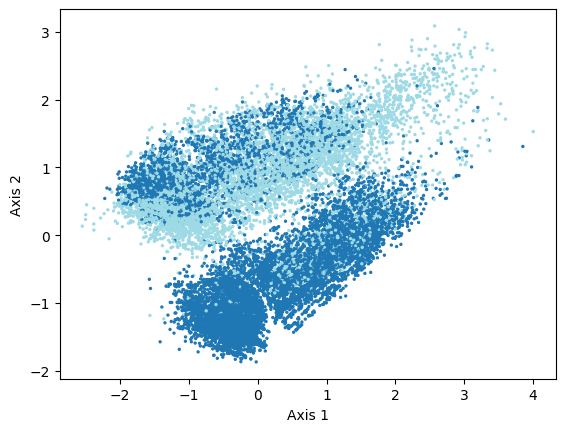

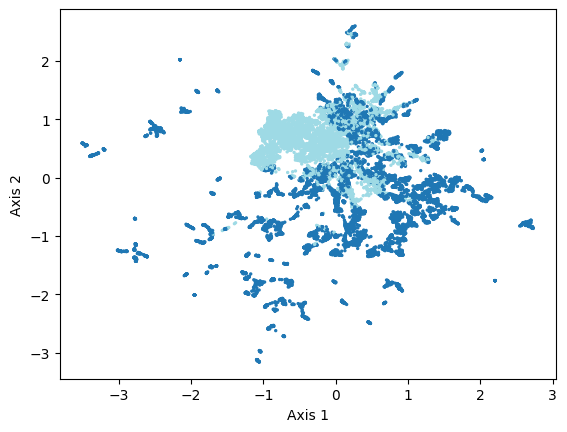

Dunn Index		:  3.2138802421890706
Silhouette Score	:  0.0813368251350469
PScore			:  96.07843137254902
NClusters		:  2



Dunn Index		:  1.9564416934853053
Silhouette Score	:  0.18526773
PScore			:  88.88888888888889
NClusters		:  2





d:\appdata\Miniconda\envs\tf\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
Cluster = KMeans(n_clusters = 2  , random_state = 64 , algorithm = 'elkan' , init = 'k-means++').fit_predict(NDSpace)
Score.Visualize2D(D2Space , Labels = Cluster)
Score.Visualize2D(D2Manifold , Labels = Cluster)
Score.TriScore(Dataset = Dataset , Labels = Cluster)
Score.TriScore(Dataset = NDSpace , Labels = Cluster)

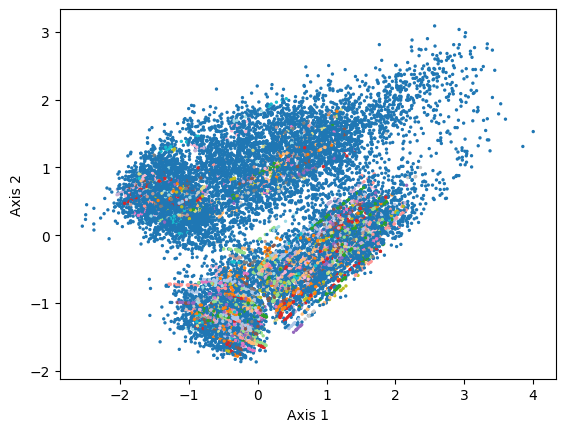

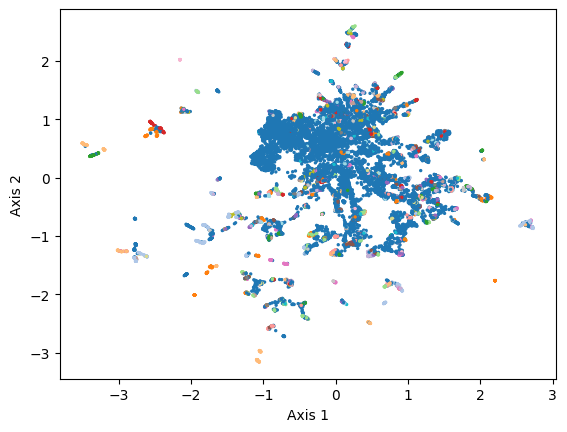

Dunn Index		:  9.12603662428875
Silhouette Score	:  -0.42418368498710635
PScore			:  76.47058823529412
NClusters		:  629



Dunn Index		:  1.2518233597545283
Silhouette Score	:  -0.22296438
PScore			:  88.88888888888889
NClusters		:  629





d:\appdata\Miniconda\envs\tf\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
Cluster = DBSCAN(eps = 0.5 , min_samples = 5).fit_predict(NDSpace)
Score.Visualize2D(D2Space , Labels = Cluster)
Score.Visualize2D(D2Manifold , Labels = Cluster)
Score.TriScore(Dataset = Dataset , Labels = Cluster)
Score.TriScore(Dataset = NDSpace , Labels = Cluster)

d:\appdata\Miniconda\envs\tf\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


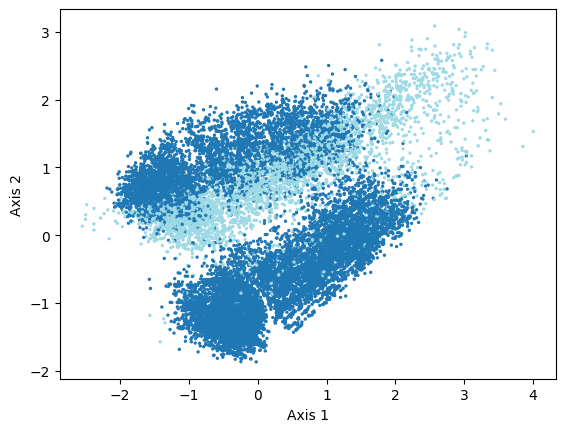

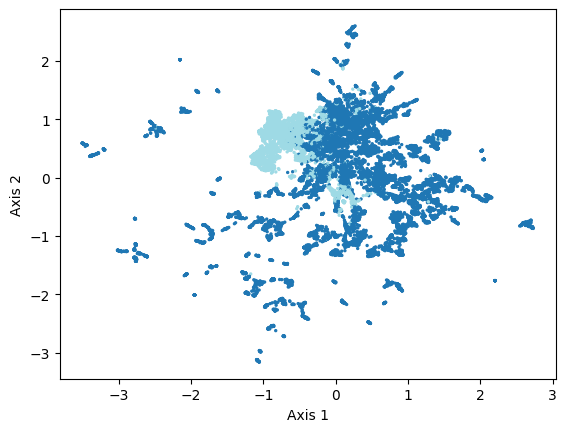

Dunn Index		:  2.5807703150392256
Silhouette Score	:  0.1263804948102144
PScore			:  86.27450980392157
NClusters		:  2



Dunn Index		:  1.9721780918806298
Silhouette Score	:  0.18080822
PScore			:  88.88888888888889
NClusters		:  2





d:\appdata\Miniconda\envs\tf\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
Cluster = AgglomerativeClustering(n_clusters = 2 , affinity = 'euclidean' , linkage = 'ward').fit_predict(NDSpace)
Score.Visualize2D(D2Space , Labels = Cluster)
Score.Visualize2D(D2Manifold , Labels = Cluster)
Score.TriScore(Dataset = Dataset , Labels = Cluster)
Score.TriScore(Dataset = NDSpace , Labels = Cluster)